# Traffic Predict System

## Introduction

In this project, we try to use some traffic data to predict the traffic jam in a certain area. In order to predict such phenomenon, we need to build a model based on some data that we can collect. The first data we came up with was the real time traffic count in the area. As we searching for the real time traffic data, we realize that it's almost impossible to find any data in real time. Most of the free data, of the traffic count, is in statical format or historical and aggregated. 

### Goal
Specifically, our goal is to predict the approximate alert count(or *alert level*) given a set of hourly features as input. In order to do that, we extract several features from the raw data we crawled, and feed them into a CNN model with PyTorch. We make predictions with this model and get a satisfying accurancy. Finally we present our results with a visulization system using D3.js 

## Data Source - Waze
Then, the waze.com came in to our sight.Waze is GPS navigation software that works on smartphones and tablets with GPS support. It provides turn-by-turn navigation information and user-submitted travel times and route details, while downloading location-dependent information over a mobile telephone network. Waze describes its app as a community-driven GPS navigation app. It encourages users to post anything that would slow down the traffic or anything need to be care about on the map.Also this app will show any active drivers/users on the map. If we can collect it，then we can start our project. Luckily, besides the app, WAZE also provides a web live map, which shows exactually the same thing as the app shows. By collecting data on the web live map,we get the initial data we need.

### The web live map
![live map](https://i.imgur.com/aDqi8JK.jpg "Live map")

### List of data collected from waze
#### Alert
Alert is a data point submitted by the active users. An alert may belong to different category, For example construction site, car accident or even "Police Nearby". We believe that the more alerts on the map, the worse the traffic is.
#### User Location
We also collect the active users on the map. We use the user lcoation to simulate the traffic density on the map.
#### User Speed
Besides users'location, we also collect the users' speed on the road.

### Problem
The only problem is that the data point is too sparse, there should be far more traffic thant it shows on the app. So in order to make the data less sparse, we need some method to aggregate our data. What we find is to use the census tracts to aggregrate our data.

### Census Tracts
Census Tracts are small, relatively permanent statistical subdivisions of a county or equivalent entity that are updated by local participants prior to each decennial census as part of the Census Bureau's Participant Statistical Areas Program.  The Census Bureau delineates census tracts in situations where no local participant existed or where state, local, or tribal governments declined to participate. The primary purpose of census tracts is to provide a stable set of geographic units for the presentation of statistical data. Census tracts generally have a population size between 1,200 and 8,000 people, with an optimum size of 4,000 people. Census tract boundaries generally follow visible and identifiable features.  They may follow nonvisible legal boundaries, such as minor civil division (MCD) or incorporated place boundaries in some states and situations, to allow for census-tract-to-governmental-unit relationships where the governmental boundaries tend to remain unchanged between censuses.  

### Demographic Data
We also collect a bunch of demographic data associate with each census tracts, for example the resident count, the average commuter time to work place of residents and the area of the census tracts. We believe it can help our model to get better correctness.

### Weather Data
It is common sense that the weather does affect the traffic. So we also collect it as the input variable of our model. Sometimes, a city has mulitiple weather stations, so we try to mapping our census tracts with the weather data from the nearest weather station. 

## Practical Datascience Trainer
Here we will first load data, which is crawled from Waze

In [1]:
# import modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm

from logger import ModelLogger, getLogger
from meter import AverageMeter
from helper import to_tensor, to_variable, BaseTrainer
import helper

import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
log = getLogger()
torch.__version__

'0.2.0_4'

### Args

In this part, we provide a clean way to tune hyperparameters. 
- first part is related with training process.
- if you want to load pretrained model, set is_load to True.
- It contains 3 mode: 'train', 'infer', 'test'

In [30]:
args = {}
args['epochs'] = 5
args['max_iter'] = -1
args['val_frac'] = 0.1
args['batch_size'] = 16
args['val_batch_size'] = 32
args['test_batch_size'] = 1
args['num_workers'] = 0
args['clip'] = 0.05
args['lr'] = 0.001
args['wd'] = 2e-5
args['shuffle'] = True

args['display_interval'] = 100
args['calc_acc_interval'] = 1
args['val_interval'] = 1
args['val_display_interval'] = 50

args['test_interval'] = 1000
args['save_threshold'] = 300

# directory relatied
args['save_directory'] = 'output'
args['is_log'] = False
args['logdir'] = './logs'
args['best_model'] = 'model_1525721489_0.8618.t7'
args['cuda'] = torch.cuda.is_available()

args['is_load'] = False
args['mode'] = 'train' # 'train', 'infer', 'test'
args = helper.parser(args)
# %lprun -f Trainer.train -u 1 main(args)

### Load Data

The original data crawled from Wave is orgainzed as per hour and per Census Tract, which is not suitable for our machine learning algorithm. We want to combine Census Tracts and add some useful static Tract data in it. Besides that, normalize is a really important technique, which should be applied.

In [31]:
import pandas as pd
df = pd.read_pickle('./Chicage_data.p')
static = np.load('./Chicage_static.npy')
n = []
for d in df.groupby(['order']):
    # for every hour, their is an distinct 'order' column behaves as 'id'
    tmp = d[1].sort_values(['ct']).drop(['ct', 'order', 'outlook', 'alert_count'], axis=1)
    tmp['time'] = tmp['time'].dt.hour
    n.append(tmp)

# convert list to np.ndarray
ns = np.array([np.asarray(i) for i in n]).transpose((0, 2, 1))

# add part of static features
ns = np.array([np.concatenate([n, static[:,[1, 3, -1]].T], axis=0) for n in ns])
# normalize
ns = (ns - ns.mean(axis=-1, keepdims=True)) / (ns.max(axis=-1, keepdims=True) + 1e-5)

### Make Label
Here we define our label is: the alert_level of the whole city. It is separated to 5 level:
- Level 1: alert count from 1~99
- Level 2: alert count from 100~199
- Level 3: alert count from 200~249
- Level 4: alert count from 250~350
- Level 5: alert count from 351~500

In [32]:
labels = np.array([np.asarray(d[1]['alert_count']) for d in df.groupby(['order'])])
labels = labels.sum(-1)
level_labels = []
for i, l in enumerate(labels):
    if l > 500:
        level_labels.append(4)
    elif l > 350:
        level_labels.append(3)
    elif l > 200:
        level_labels.append(2)
    elif l > 100:
        level_labels.append(1)
    else:
        level_labels.append(0)
level_labels = np.array(level_labels)

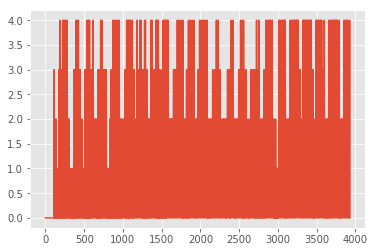

In [33]:
plt.plot(level_labels)
plt.show()

In [34]:
raw_dev_data = ns # data_count, feature_size, blocks
raw_dev_label = level_labels

In [35]:
class BlockDataset(Dataset):
    def __init__(self, datas, labels, test=False):
        super().__init__()
        if test or labels is None:
            labels = [np.zeros(1, dtype=np.int32) for _ in datas]

        self.datas = [to_tensor(d) for d in datas]
        self.labels = to_tensor(labels)
        self.len = len(datas)

    def __getitem__(self, index):
        return self.datas[index], self.labels[index]

    def __len__(self):
        return self.len

### CNN Model
The model is really simple, but it works for the dataset.

First is a sequence of feature detector, followed by a classifier. In feature detector, we use 3 1D Convolution Layer, LeakyReLU and MaxPooling.

In [36]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv1d(in_channels, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(256, 256, kernel_size=3, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(256, 256, kernel_size=3, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes),
        )

    def forward(self, input):
        features =  self.seq(input)
        features = torch.mean(features, dim=-1)
        return self.classifier(features)

### DataLoader
In Pytorch, the data is often got from dataloader, here we define train loader and validation loader.

In [38]:
def get_dataloaders(args, Dataset, train, labels, test = None):
    kwargs = {'num_workers': args.num_workers, 'pin_memory': True} if args.cuda else {}

    train_dataset = Dataset(train, labels)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=args.shuffle,
        **kwargs)
    val_dataset = Dataset(train, labels)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=args.val_batch_size,
        shuffle=False,
        **kwargs)
        
    train_size = len(train_dataset)
    val_size = len(val_dataset)
    return {
        'train_loader': train_loader,
        'train_size': train_size,
        'val_loader': val_loader,
        'val_size': val_size,
        'test_loader': None, 
        'test_size': 0
    }

### Model Trainer

In [39]:
class Trainer(BaseTrainer):
    def __init__(self, model, optimizer, scheduler, loss_fn, loader, args):
        super().__init__(model, optimizer, scheduler, loss_fn, loader, args)
    
    def accuracy(self, pred, label_masked):
        pred = pred.data.cpu().numpy().argmax(-1)
        acc = np.abs(pred == label_masked.cpu().numpy()).sum() / label_masked.size(0)
        return float(acc)
    
    def train(self, epoch):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        correct = AverageMeter()

        self.model.train()
        end = time.time()
    
        for batch_idx, (features, labels) in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            # measure data loading time
            data_time.update(time.time() - end)
            
            prediction = self.model(to_variable(features).float())
            loss = self.loss_fn(prediction, to_variable(labels))
            loss.backward()
            losses.update(loss.data.cpu()[0]/features.size(0)*0.6, features.size(0))
            # compute gradient and take a baby step
            clip_grad_norm(self.model.parameters(), args.clip)
            self.optimizer.step()
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            def post_print():
                """
                It calculates accuracy and print pretty format log
                """
                step = epoch * len(self.train_loader) + losses.count // self.args.batch_size

                if batch_idx == 0:
                    return True

                if batch_idx % self.args.calc_acc_interval == 0:
                    # calculate acc
                    curr_correct = self.accuracy(prediction, labels)
                    correct.update(curr_correct, features.size(0))
                    self.logger.log_train_info(losses.avg, correct.avg, step)

                if batch_idx % self.args.display_interval == 0:
                    # display and log
                    info = 'Epoch: [{0}][{1}/{2}]\tTime {batch_time:2.2f}m\tLoss {loss.val:.4f}[{loss.window_avg:.4f}]\t'.format(
                              epoch,
                              batch_idx,
                              len(self.train_loader),
                              batch_time=batch_time.sum / 60,
                              data_time=data_time,
                              loss=losses)
                    if batch_idx % self.args.calc_acc_interval == 0:
                        acc_info = 'Acc {train_acc.val:.4f}[{train_acc.window_avg:.4f}]'.format(train_acc=correct)
                        info += acc_info
                    log.info(info)
                return True
            if not post_print():
                break
        return correct.window_avg, losses.window_avg

    def inference(self):
        global x
        batch_time = AverageMeter()
        correct = AverageMeter()
        self.model.eval()
        end = time.time()
        losses = AverageMeter()
        for batch_idx, (features, labels) in enumerate(self.val_loader):
            prediction = self.model(to_variable(features).float())
            loss = self.loss_fn(prediction, to_variable(labels))
            losses.update(loss.data.cpu()[0]/features.size(0), features.size(0))
            # measure accuracy
            curr_correct = self.accuracy(prediction, labels)
            correct.update(curr_correct, features.size(0))

            #measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            x.append(prediction.data.cpu().numpy())
            if batch_idx == 0:
                continue
            if batch_idx % self.args.val_display_interval == 0:
                info = '[{0}/{1}]\tTime {batch_time:2.2f}m\tAcc {val_acc.val:.4f}[{val_acc.avg:.4f}]\tLoss {losses.val:.4f}[{losses.avg:.4f}]'.format(
                      batch_idx,
                      len(self.val_loader),
                      batch_time=batch_time.sum / 60,
                      val_acc=correct,
                      losses=losses)
                log.info(info)
        return correct.avg, losses.avg
    
    def produce_test(self, res, epoch):
        a = []
        for d in df.groupby(['order']):
            record = d[1].sort_values(['ct'])
            m = (record['time'].iloc[0].strftime('%Y%m%d'), record['time'].iloc[0].strftime('%H'))
            a.append(m)
        nn = np.vstack(x).argmax(-1)
        a = pd.DataFrame(a, columns=['date','hour'])
        a['pred'] = nn
        a.to_csv('stupid_weng.csv', index=False)

### Exec
Here is the place we execute our deep learning network. The loss function is CrossEntropyLoss, which is popular in classification task.

In [40]:
x = []
def main(args):
    loader = get_dataloaders(args, BlockDataset, raw_dev_data, raw_dev_label)
    model = CNN(in_channels=9, num_classes=5)
    optimizer = torch.optim.Adam(model.parameters(), lr = args.lr, weight_decay=args.wd)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, scheduler, loss_fn, loader, args)
    trainer.run(args.epochs)

main(args)

train size: 3928, val size: 3928
begin training...
Epoch: [0][100/246]	Time 0.63m	Loss 0.0693[0.0496]	Acc 0.3750[0.7275]
Epoch: [0][200/246]	Time 1.20m	Loss 0.0485[0.0453]	Acc 0.6562[0.6900]
[50/123]	Time 0.16m	Acc 0.5938[0.5153]	Loss 0.0289[0.0371]
[100/123]	Time 0.32m	Acc 0.5312[0.5507]	Loss 0.0372[0.0349]
 * epoch [0]:	train_loss 0.0425	train_acc 0.8025	val_loss 0.0350	val_acc 0.5532


model saved output/model_1526085933_0.8025.t7, best_acc is 0.802500


Epoch: [1][100/246]	Time 0.58m	Loss 0.0407[0.0466]	Acc 0.7500[0.6863]
Epoch: [1][200/246]	Time 1.13m	Loss 0.0410[0.0413]	Acc 0.9375[0.8025]
[50/123]	Time 0.16m	Acc 0.4062[0.5870]	Loss 0.0342[0.0326]
[100/123]	Time 0.32m	Acc 0.4688[0.5254]	Loss 0.0397[0.0338]
 * epoch [1]:	train_loss 0.0397	train_acc 0.8363	val_loss 0.0342	val_acc 0.5193


model saved output/model_1526086039_0.8363.t7, best_acc is 0.836250


Epoch: [2][100/246]	Time 0.62m	Loss 0.0524[0.0416]	Acc 0.8438[0.7913]
Epoch: [2][200/246]	Time 1.19m	Loss 0.0402[0.0397]	Acc 0.7500[0.8175]
[50/123]	Time 0.16m	Acc 0.4062[0.5766]	Loss 0.0306[0.0322]
[100/123]	Time 0.33m	Acc 0.5312[0.5266]	Loss 0.0374[0.0325]
 * epoch [2]:	train_loss 0.0436	train_acc 0.7913	val_loss 0.0328	val_acc 0.5224


model saved output/model_1526086150_0.7913.t7, best_acc is 0.836250


Epoch: [3][100/246]	Time 0.62m	Loss 0.0615[0.0433]	Acc 0.5625[0.7350]
Epoch: [3][200/246]	Time 1.28m	Loss 0.0398[0.0400]	Acc 0.8438[0.8325]
[50/123]	Time 0.21m	Acc 0.5312[0.5558]	Loss 0.0286[0.0328]
[100/123]	Time 0.37m	Acc 0.4688[0.5427]	Loss 0.0354[0.0318]
 * epoch [3]:	train_loss 0.0435	train_acc 0.7650	val_loss 0.0320	val_acc 0.5446


model saved output/model_1526086271_0.7650.t7, best_acc is 0.836250


Epoch: [4][100/246]	Time 0.66m	Loss 0.0377[0.0437]	Acc 0.9375[0.7087]
Epoch: [4][200/246]	Time 1.30m	Loss 0.0396[0.0409]	Acc 0.6562[0.8287]
[50/123]	Time 0.16m	Acc 0.5938[0.5453]	Loss 0.0295[0.0331]
[100/123]	Time 0.32m	Acc 0.4688[0.5424]	Loss 0.0353[0.0318]
 * epoch [4]:	train_loss 0.0394	train_acc 0.8213	val_loss 0.0320	val_acc 0.5448


model saved output/model_1526086387_0.8213.t7, best_acc is 0.836250


### SVM
In order to get to know how well our system is, we write following code, and try to predict using SVM, the result shows that, our model is much higher than SVM, which should be brought by cnn as detector and the non-linearity of neural network

In [45]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(raw_dev_data[:-100].reshape(-1, 795*9), raw_dev_label[:-100])
res = clf.predict(raw_dev_data[-100:].reshape(-1, 795*9))
print('The prediction of SVM is : ', np.mean(res == raw_dev_label[-100:]))

The prediction of SVM is :  0.41


## Visualization

After extracted all these features and predicted the result, we built a visualization demo system to better present our results.

### Features and Encoding

We used 9 features to train our predict model. Some of them are encoded with the color shade, for example, darker color represents larger value in quantity; Some are inherently encoded like the area of census tracts; Some are adjustable by dragging slider bars, such as time and hour. Finally the predicted alert level is encoded by both colors and lengths;

### Examples

Below we provide a couple of demo examples of the visualization. Generally, the map in the middle shows the distributions of features and the bar on the right show the current alert level at the given time. Users can change the time with two sliders on the bottom, which represent date and hour respectively.

Firstly, by clicking different feature buttons, the map will display correspondingly. 

![user density](https://image.ibb.co/grm28y/688_1.png)

Currently it shows the user density and we can change it to show the speed of cars.

![speed](https://image.ibb.co/kgwDFd/688_2.png)

Also we can see the result of different day and hours, by dragging the slider bars.

![time](https://image.ibb.co/jCizoy/688_3.png)


## Future work

First, as you may notice, the data we collected is quite sparse which limits our prediction. Therefore we want to find other data sources with richer content so that we can predict the traffic alert level with smaller geographic granularity. 

Second, although we have tried some different metrics already, the features we chose to train and to predict could be further pruned. And with more data we collect, more hidden correlation may be revealed by this kind of attempts.

Besides, some alternate learning methods, like GAN, RNN, are also worth trying to optimizing our results. 